<a href="https://colab.research.google.com/github/kenichi-maeda/cs666student/blob/main/CS666_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

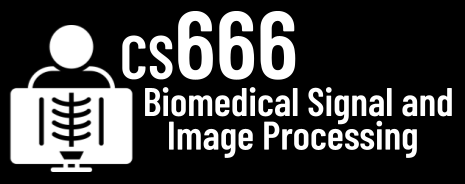
#Assignment 4

In [1]:
# NAME: Kenichi Maeda

In [2]:
# In this assignment, we will create a Random Forest classifier to detect pneumonia and covid in xrays!

In [3]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# we are using mahotas again, so lets install it!
!pip install mahotas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 8.4 MB/s eta 0:00:00


In [5]:
# our imports include sklearn this time
import mahotas as mh
import os
from sklearn.ensemble import RandomForestClassifier

**Task 1:** Download, extract, and load the data! [15 Points]

In [6]:
# Please download this file: https://cs666.org/data/xray/ with the wget command!
# Note: Please use the forwarded dropbox link and change dl=0 to dl=1!
# This is a subset of the Kaggle Pneumonia + Covid Datasets!
!wget https://www.dropbox.com/s/2ca2889o2ql8n4e/xray.zip?dl=1

--2024-03-31 17:44:03--  https://www.dropbox.com/s/2ca2889o2ql8n4e/xray.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/2ca2889o2ql8n4e/xray.zip [following]
--2024-03-31 17:44:03--  https://www.dropbox.com/s/dl/2ca2889o2ql8n4e/xray.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce54733ffca50e2fd9136a84376.dl.dropboxusercontent.com/cd/0/get/CQJUO2qaV6VLMNpKyov4bUZ7mr8RD6PyI-3xTIIzAfsDOYosb1NAxpHWflLnH_QJ6dH8MeDEVQjhFppK-lf5lrbTlFQQBa0dAjtCDYFFGNU7L-oY1id-MCZRuEi4gaP2h3lGWqVJ2vx1NpbBDBpF6YPf/file?dl=1# [following]
--2024-03-31 17:44:03--  https://uce54733ffca50e2fd9136a84376.dl.dropboxusercontent.com/cd/0/get/CQJUO2qaV6VLMNpKyov4bUZ7mr8RD6PyI-3xTIIzAfsDOYosb1NAxpHWflLnH_QJ6dH8MeDEVQjhFppK-lf5lrbTlFQQBa0dAjtCDYFFGNU7L-oY

In [7]:
# Run this code to extract the zip file and to create
# the folder structure of normal/, pneumonia/, and covid/ images.
# Each folder contains the first images of the Kaggle datasets.
import zipfile
with zipfile.ZipFile('xray.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

NORMAL_DIR = 'normal/'
PNEUMONIA_DIR = 'pneumonia/'
COVID_DIR = 'covid/'

In [8]:
# Here we load the first image from the normal dataset.
img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg')

In [ ]:
# TODO: Please display this image and print the dimensions!

In [9]:
# TODO: YOUR CODE
img.shape

(1858, 2090)

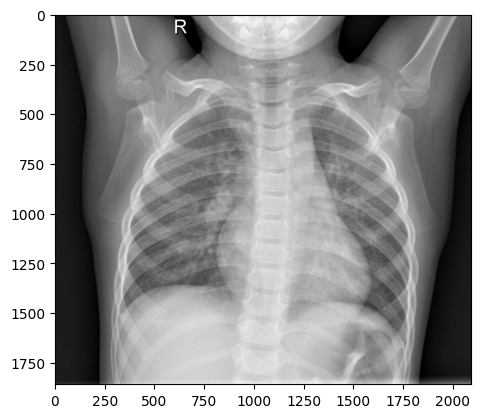

In [10]:
imshow(img, cmap='gray')

**Task 2:** Let's do some data wrangling and more visualization! [30 Points]

In [11]:
folders = [NORMAL_DIR, PNEUMONIA_DIR, COVID_DIR]
data = [[],[],[]]

for f_index,f in enumerate( folders ):
  all_files = os.listdir( f )

  data[f_index] = np.zeros( (len(all_files), 300, 300), dtype=np.float32)

  for i in range(len(all_files)):
    loaded_image = mh.imread( f + '/' + all_files[i] )
    if loaded_image.ndim > 2:
      loaded_image = mh.colors.rgb2gray(loaded_image[:,:,:3])

    loaded_image = mh.imresize( loaded_image, (300, 300) )
    img_shape = loaded_image.shape

    data[f_index][ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [12]:
# The two code blocks above perform 3 data wrangling operations.
# Which ones?
# Hint: The first two might be more obvious but the third one happens in the
# last line.
# TODO: Operation 1) Convert images to a gray scale
# TODO: Operation 2) Convert the dimension of images to (300, 300)
# TODO: Operation 3) Load converted images to appropriate lists (e.g., if normal, then data[0])

In [13]:
# Now, let's look at the first 5 normal_images and the first 5 pneumonia_images.
# TODO: Please visualize multiple images at once.
# Hint: You can use one of the following answers from StackOverflow for this:
# https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images

<Figure size 640x480 with 0 Axes>

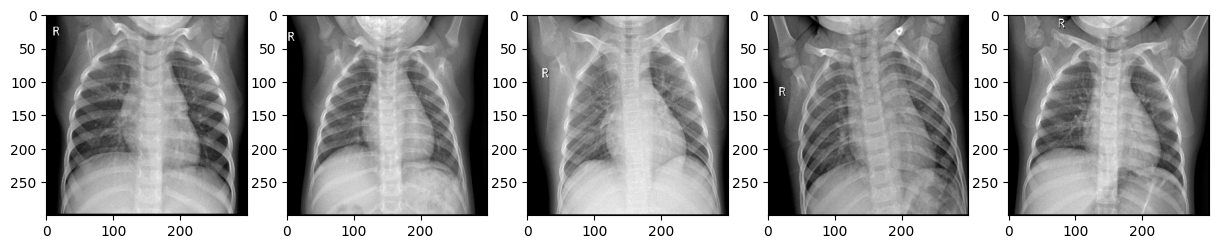

In [14]:
# TODO: YOUR CODE

# normal_images
plt.figure()
plt.gray()
f, axis = plt.subplots(1, 5, figsize=(15, 15))
axis[0].imshow(data[0][0])
axis[1].imshow(data[0][1])
axis[2].imshow(data[0][2])
axis[3].imshow(data[0][3])
axis[4].imshow(data[0][4])

plt.show()

<Figure size 640x480 with 0 Axes>

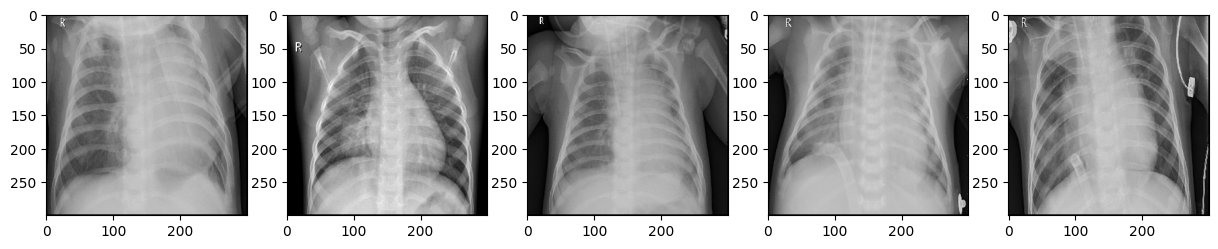

In [15]:
# pneumonia_images
plt.figure()
plt.gray()
f, axis = plt.subplots(1, 5, figsize=(15, 15))
axis[0].imshow(data[1][0])
axis[1].imshow(data[1][1])
axis[2].imshow(data[1][2])
axis[3].imshow(data[1][3])
axis[4].imshow(data[1][4])

plt.show()

**Task 3:** Setup training and testing data. [15 Points]

In [16]:
# Any supervised machine learning algorithm requires disjunct sets of
# training and testing data.
#
# For each, we will create a balanced dataset that includes an equal number
# of normal xrays, pneumonia xrays, and covid xrays.
#
# The training data X_train will include 180 images (60 normal, 60 pneumonia, 60 covid).
# The testing data X_test will include the remaining 120 images (40 normal, 40 pneumonia, 40 covid).
#
# Supervised learning means that we tell the algorithm which image is normal
# and which image is pneumonia. For this, we need the y_train vector.
# The vector shall be 0 for a normal image, and 1 for a pneumonia, and 2 for a covid scan.

In [17]:
TRAINING_COUNT = 60

X_train = np.zeros( (TRAINING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TRAINING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_train[t_pos] = image
    t_pos += 1

In [18]:
# TODO: Please create the y_train vector with 0 for a normal image,
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_train = np.zeros( (TRAINING_COUNT * 3, 1 ), dtype=np.float32).ravel()

y_train[:60] = [0.]
y_train[60:120] = [1.]
y_train[120:] = [2.]

In [19]:
TESTING_COUNT = 40

X_test = np.zeros( (TESTING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  #for image in d[0:TESTING_COUNT]:
  for image in d[TRAINING_COUNT:TRAINING_COUNT+TESTING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test[t_pos] = image
    t_pos += 1


In [20]:
# TODO: Please create the y_test vector with 0 for a normal image,
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_test = np.zeros( (TESTING_COUNT * 3, 1 ), dtype=np.float32).ravel()

y_test[:40] = [0.]
y_test[40:80] = [1.]
y_test[80:] = [2.]

**Task 4:** Let's train and evaluate the Random Forest! [30 Points]

In [21]:
# Let's shuffle our training data.
p = np.random.permutation(len(X_train))
X_train = X_train[p]
y_train = y_train[p]

In [22]:
# With scikit-learn, we can easily set up a default Random Forest classifier.
clf = RandomForestClassifier()

In [23]:
# Now, we train the classifier with the training data and the training targets.
# We essentially show the classifier an image and tell whether the image is
# normal or pneumonia or covid.
fitted = clf.fit( X_train, y_train)

In [ ]:
# TODO: In just a few sentences, please explain how the Random Forest works.

In [ ]:
# TODO:
# Random Foresrt is one of the Machine Learning algorithms typically used for classification.
# It consists of a bunch of decision trees, and the model makes a prediction based on the outputs
# of each tree. Of course, we need to give a trainign set with a label beforehand so that each
# decision tree or model itself can decide what to output.

In [24]:
# After training, we can see how well the classifier predicts our testing data.
# The following command will return the classification accuracy.
clf.score( X_test, y_test )

0.85

In [ ]:
# TODO: Is the classification accuracy good? And, are you surprised?

In [25]:
# TODO: Yes! I'm surprised!

**Task 5:** Now, let's decrease the number of trees! [10 Points]

In [ ]:
# How many trees are used in Task 4?

In [26]:
# TODO: YOUR ANSWER
print("The number of trees in the forest:",clf.n_estimators)

The number of trees in the forest: 100


In [ ]:
# Now, please use a single tree and observe the testing performance.

In [27]:
# TODO: YOUR CODE
clf = RandomForestClassifier(n_estimators=1)
fitted = clf.fit( X_train, y_train)
clf.score( X_test, y_test )

0.7

In [ ]:
# Are you surprised?

In [ ]:
# TODO: Yes!

**Bonus:** Let's take a closer look! [33 Points]

In [ ]:
# Let's run the fitted classifier on the remaining covid images.
# You might have noticed that there are 199 covid images but we only used 100 so far.
# Please evaluate the classifier on the remaining (previously unseen) 99 covid images
# and check the performance.

In [28]:
# TODO: YOUR CODE AND YOUR ANSWER

# Make a new test set
NEW_TESTING_COUNT = 99

X_test_covid_only = np.zeros( (NEW_TESTING_COUNT, 300*300 ), dtype=np.float32)
t_pos = 0

for image in data[2][100:]:
  image = image.ravel() # flatten the image
  image /= image.max() # normalize the image
  X_test_covid_only[t_pos] = image
  t_pos += 1

# Make a label for the new test set
y_test_covid_only = np.zeros( (NEW_TESTING_COUNT, 1 ), dtype=np.float32).ravel()

y_test_covid_only [:] = [2.]

# See the performance
clf = RandomForestClassifier()
fitted = clf.fit( X_train, y_train)
print(clf.score( X_test_covid_only, y_test_covid_only  ))

0.9292929292929293


In [ ]:
# Can you figure out which images were misclassified?
# Hint: You can use predictions = clf.predict(X_test_covid_only) for this.
# Can you display them?
# Do you have an idea why these images were problematic?

Predictions
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2.]
Misclassified Images Indicies
[[11]
 [12]
 [32]
 [47]
 [59]
 [60]
 [81]]


<ipython-input-30-72e784c593e3>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axis[0].imshow(data[2][100+int(misclassified_images_indicies[0])])
<ipython-input-30-72e784c593e3>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axis[1].imshow(data[2][100+int(misclassified_images_indicies[1])])
<ipython-input-30-72e784c593e3>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axis[2].imshow(data[2][100+int(misclassified_images_indicies[2])])
<ipython-input-30-72e7

<Figure size 640x480 with 0 Axes>

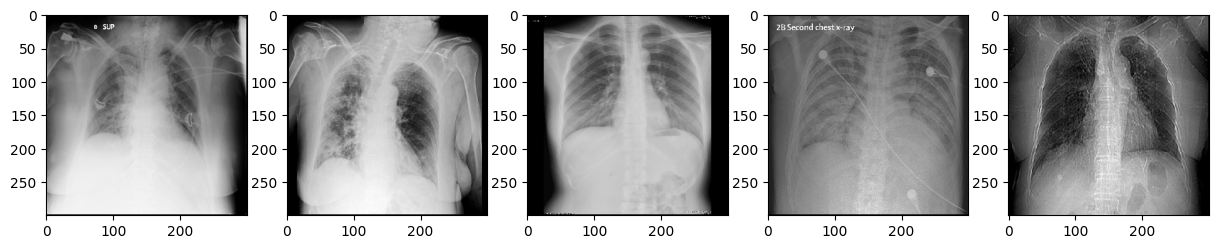

In [30]:
# TODO:
predictions = clf.predict(X_test_covid_only)
misclassified_images_indicies = np.argwhere(predictions!=2.)

print("Predictions")
print(predictions)
print("Misclassified Images Indicies")
print(misclassified_images_indicies)

plt.figure()
f, axis = plt.subplots(1, 5, figsize=(15, 15))
axis[0].imshow(data[2][100+int(misclassified_images_indicies[0])])
axis[1].imshow(data[2][100+int(misclassified_images_indicies[1])])
axis[2].imshow(data[2][100+int(misclassified_images_indicies[2])])
axis[3].imshow(data[2][100+int(misclassified_images_indicies[3])])
axis[4].imshow(data[2][100+int(misclassified_images_indicies[4])])

plt.show()
# These are covid images, but they resemble the ones for pneumonia.

In [ ]:
# Great job!!!
#           ___
#       _.-'   \
#      /        \
#     /          \
#    /            `.___
#   ( .--.)\/(,.--.    `-.
#   ,',-. \   / ,-.`.     )
#  ( /   \     /   \ )   / \
#   || .-|     |-. ||---'|  \
#  _|| | |     | | ||_   |   \
# /. \ |_|.---.|_| / ,\  | .^.\
# `.\ `--"     "--' /,'  |/
#   `>  _________ <'
# ,-' ,---.---.---. `-.
# `--'\    \j/    /`--'
#    `.\         /,'
#      \\_______//
#       `-------'       hjw